In [2]:
import os
from this import d
import cv2
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import mediapipe as mp

### Haar Cascade Face recognition (OpenCV)

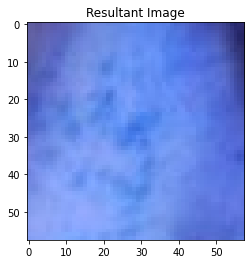

In [27]:
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
nose_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_mcs_nose.xml")

def face_detection_Haar_Cascade(img):
    faces = face_detector.detectMultiScale(img)
    if (len(faces) <= 0):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img, img_gray
    else:
        X, Y, W, H = faces[0]
        img = img[int(Y):int(Y+H), int(X):int(X+W)]
        return img, cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

img = cv2.imread("images/in/face4.jpg")

new_img, b = face_detection_Haar_Cascade(img)
plt.title("Resultant Image");plt.imshow(new_img);plt.show()

# cv2.imshow('Resultant Image',new_img)
# cv2.waitKey(0) 
# cv2.destroyAllWindows() 

### Frontal face detector DNN

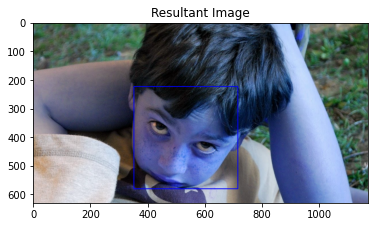

In [28]:
modelFile = "models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "models/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
img = cv2.imread('images/in/face4.jpg')
h, w = img.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
(300, 300), (104.0, 117.0, 123.0))
net.setInput(blob)
faces = net.forward()
#to draw faces on image
for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        if confidence > 0.5:
            box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            cv2.rectangle(img, (x, y), (x1, y1), (0, 0, 255), 2)
            # cv2.imshow('a',img)
            # cv2.waitKey(0) 
            # cv2.destroyAllWindows() 

plt.title("Resultant Image");plt.imshow(img);plt.show()

### Mediapipe Fash Mesh Model

In [15]:
def face_detection_face_mesh(image):
    landmarks_list = [np.zeros(shape=(478,3))] * 1

    face_mesh = mp.solutions.face_mesh
    face_mesh = face_mesh.FaceMesh(
                    static_image_mode=True,
                    max_num_faces=1,
                    refine_landmarks=True,
                    min_detection_confidence=0.3
                )

    results = face_mesh.process(image)
    if results.multi_face_landmarks == None:
        return None

    for i in range(len(results.multi_face_landmarks)):
        for j in range(0, len(results.multi_face_landmarks[i].landmark)):
            landmarks_list[i][j, 0] = int(results.multi_face_landmarks[i].landmark[j].x * image.shape[1])
            landmarks_list[i][j, 1] = int(results.multi_face_landmarks[i].landmark[j].y * image.shape[0])
            landmarks_list[i][j, 2] = int(results.multi_face_landmarks[i].landmark[j].z * image.shape[0])

    print(img.shape)
    return landmarks_list[0][133], landmarks_list[0][362]

face_detection_face_mesh(cv2.imread("images/in/face4.jpg"))



(630, 1170, 3)


(array([477., 390., -21.]), array([560., 424., -18.]))

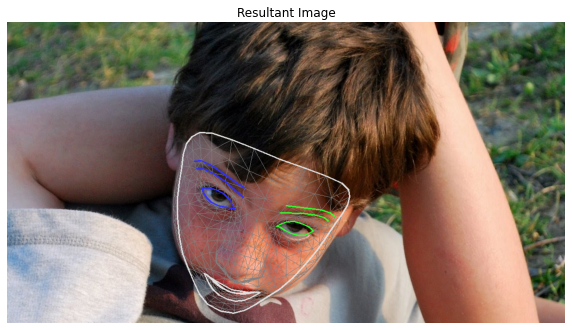

In [16]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         min_detection_confidence=0.5)

sample_img = cv2.imread('images/in/face4.jpg')

face_mesh_results = face_mesh_images.process(sample_img[:,:,::-1])
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
img_copy = sample_img[:,:,::-1].copy()

if face_mesh_results.multi_face_landmarks:
    for face_landmarks in face_mesh_results.multi_face_landmarks:

        mp_drawing.draw_landmarks(image=img_copy, 
                                  landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_TESSELATION,
                                  landmark_drawing_spec=None, 
                                  connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
        
        mp_drawing.draw_landmarks(image=img_copy, landmark_list=face_landmarks,connections=mp_face_mesh.FACEMESH_CONTOURS,
                                  landmark_drawing_spec=None, 
                                  connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

fig = plt.figure(figsize = [10, 10])
plt.title("Resultant Image");plt.axis('off');plt.imshow(img_copy);plt.show()

### Face Alignment Using Left & Right Eye Co-ordinates

In [11]:
def euclidean_distance(a, b):
    return math.sqrt(((b[0] - a[0]) * (b[0] - a[0])) +\
                     ((b[1] - a[1]) * (b[1] - a[1])))

(630, 1170, 3)
-337.724102151741
-337.724102151741


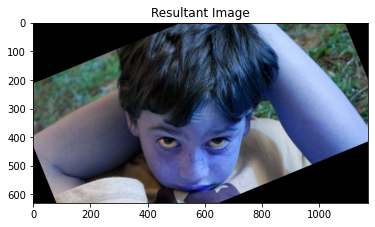

In [23]:
img = cv2.imread("images/in/face4.jpg")
img_raw = img.copy()

eye_1, eye_2 = face_detection_face_mesh(img)

if eye_1[0] > eye_2[0]:
    left_eye = eye_2
    right_eye = eye_1
else:
    left_eye = eye_1
    right_eye = eye_2

left_eye_x, left_eye_y = left_eye[0], left_eye[1]
right_eye_x, right_eye_y = right_eye[0], right_eye[1]

dY = left_eye_y - right_eye_y
dX = left_eye_x - right_eye_x
angle = np.degrees(np.arctan2(dY, dX)) - 180
print(angle)

# rotate image
new_img = Image.fromarray(img_raw)
new_img = np.array(new_img.rotate(angle))

print(angle)

test_imgs = np.empty((5,32,32,3), dtype=np.uint8)
new_img = new_img/255.
plt.title("Resultant Image");plt.imshow(new_img);plt.show()

# cv2.imshow("image",new_img)
# cv2.waitKey(0) 
# cv2.destroyAllWindows() 
